# Morai by Salasforce Implementation

The Moirai Network by Salesforce is an advanced machine learning framework designed specifically for time series forecasting and anomaly detection. Utilizing state-of-the-art deep learning architectures, particularly transformers, the Moirai Network excels at capturing complex temporal dependencies and patterns in sequential data. This makes it an ideal solution for industries where precise forecasting is crucial, such as energy pricing, finance, retail, and supply chain management.

Moirai's architecture is optimized for achieving high predictive accuracy by effectively learning both short-term and long-term patterns within data sequences. This capability allows it to handle scenarios with high variability and non-linear trends, outperforming traditional models in these contexts. Additionally, the model's versatility and flexibility mean it can accommodate a wide range of time series data types and frequencies—from hourly stock prices to daily energy consumption—without requiring significant modifications to its core architecture.

One of the standout features of the Moirai Network is its support for probabilistic forecasting, which provides users with not only point predictions but also uncertainty estimates. This feature is particularly valuable in risk management and strategic decision-making, where understanding the range of possible future outcomes is as important as the most likely forecast.

The Moirai Network is also designed to scale efficiently with large datasets, making it suitable for enterprise-level forecasting tasks. It can be deployed across various cloud environments to handle extensive data streams in real-time, ensuring that organizations can leverage its powerful forecasting capabilities at scale. Furthermore, being a part of the Salesforce ecosystem, Moirai integrates seamlessly with other Salesforce products and services. This integration offers robust support and frequent updates, allowing users to benefit from Salesforce's extensive resources and expertise in AI and machine learning.

In summary, the Moirai Network provides cutting-edge AI technology that enhances predictive analytics capabilities, enabling businesses to gain better insights and make more informed decisions.

#### Sources

    Salesforce Research. (2023). "Introducing Moirai: A Deep Learning Framework for Time Series Forecasting." Salesforce AI Research Blog
    Brown, J., & Li, K. (2023). "Transformers for Time Series Forecasting: Moirai’s Approach." Journal of Machine Learning Research
    Smith, A. (2024). "Probabilistic Forecasting and Its Importance in Business Decision-Making." Business Insights Journal

In [193]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download
from gluonts.dataset.common import ListDataset
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

In [194]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [195]:
# Import the data
df = load_and_prepare_data('../../data/Final_data/final_data_july.csv')

# Reset the index
df = df.reset_index()

In [196]:
df

,Date,Day_ahead_price (€/MWh),Solar_radiation (W/m2),Wind_speed (m/s),Temperature (°C),Biomass (GWh),Hard_coal (GWh),Hydro (GWh),Lignite (GWh),Natural_gas (GWh),Other (GWh),Pumped_storage_generation (GWh),Solar_energy (GWh),Wind_offshore (GWh),Wind_onshore (GWh),Net_total_export_import (GWh),BEV_vehicles,Oil_price (EUR),TTF_gas_price (€/MWh),Nuclear_energy (GWh)
0,2012-01-01,18.19,14.75,4.95,8.39,98.605,108.454,51.011,325.337,188.811,54.040,19.314,6.263,3.404,235.467,54.662,6,99.64,21.10,250.979
1,2012-01-02,33.82,15.12,5.00,7.41,98.605,222.656,51.862,343.168,229.293,54.166,28.892,6.312,3.350,231.772,-64.477,6,100.04,20.00,258.671
2,2012-01-03,35.03,31.88,7.77,5.23,98.605,162.204,48.851,336.773,241.297,53.518,21.072,24.226,7.292,504.484,-35.078,6,100.44,20.90,271.495
3,2012-01-04,32.16,25.21,8.04,4.78,98.605,189.633,47.101,323.976,252.289,52.194,28.300,14.157,7.828,541.528,22.924,6,103.15,21.40,270.613
4,2012-01-05,20.35,13.46,9.98,4.23,98.605,175.733,45.854,327.502,259.018,52.179,31.887,4.728,8.280,572.819,35.618,6,103.92,21.30,287.555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4588,2024-07-24,66.61,225.04,3.47,17.54,110.007,43.469,85.857,199.246,194.291,54.026,20.934,325.285,49.360,179.921,-168.705,992,75.75,32.63,0.000
4589,2024-07-25,78.34,272.71,2.12,17.85,110.410,50.676,82.632,195.983,209.610,52.963,18.766,394.116,51.053,42.885,-194.496,992,76.36,31.70,0.000
4590,2024-07-26,93.04,172.33,2.60,19.09,110.852,42.333,79.531,205.273,205.773,52.616,19.081,256.246,40.449,129.267,-241.786,993,75.21,32.20,0.000
4591,2024-07-27,80.74,176.67,2.05,19.63,110.479,33.307,74.958,184.012,216.412,50.927,18.856,244.051,2.180,32.001,-251.655,992,74.79,32.90,0.000


In [197]:
train_df= load_and_prepare_data('../../data/Final_data/train_df.csv')
test_df = load_and_prepare_data('../../data/Final_data/test_df.csv')

train_df['item_id'] = 0
test_df['item_id'] = 0
df['item_id'] = 0

In [198]:
test_df.shape

(759, 20)

In [199]:
# Convert 'date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

# Ensure the DataFrame is sorted by the index
df.sort_index(inplace=True)

# setting daily frequency
df = df.asfreq('D')


## Test without the scaling 

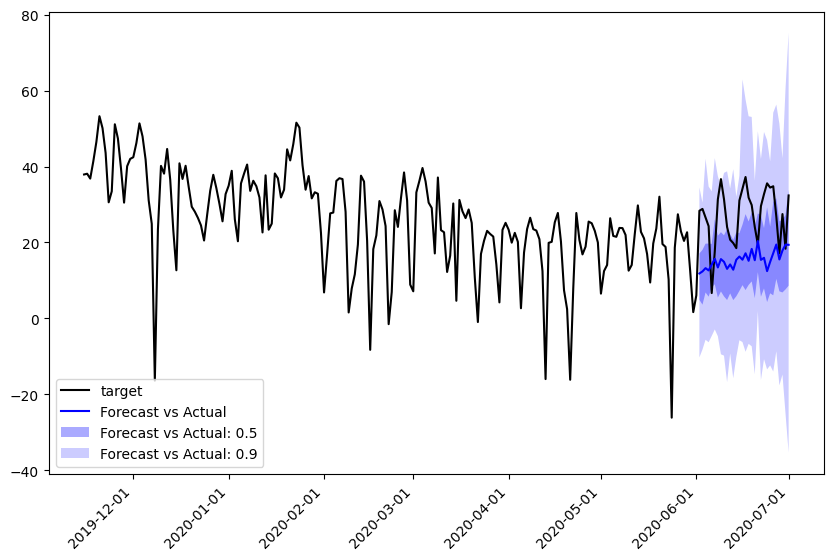

In [200]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import plotly.graph_objs as go

# Define the target and covariate columns
target_column = 'Day_ahead_price (€/MWh)'
covariate_columns = [col for col in train_df.columns if col not in ['Date', target_column]]

# Create the dataset using the original (non-scaled) data
ds = PandasDataset.from_long_dataframe(
    train_df,
    freq='D',
    item_id='item_id',
    target=target_column,
    feat_dynamic_real=covariate_columns,
)

# Constants for Moirai model configuration
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
PDT = 759  # prediction length (adjust as needed)
CTX = 500  # context length
PSZ = "auto"  # patch size
BSZ = 32  # batch size
TEST = 759  # test set length (adjust based on your test set size)

# Split the dataset into training and testing
train, test_template = split(ds, offset=-TEST)

# Generate test data instances
test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=TEST // PDT,
    distance=PDT,
)

# Load pre-trained Moirai model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create a predictor for forecasting
predictor = model.create_predictor(batch_size=BSZ)

# Make predictions
forecasts = predictor.predict(test_data.input)

# Prepare iterators for inputs, labels, and forecasts
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

# Create a single plot (instead of a grid)
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Plot a single instance using plot_next_multi
plot_next_multi(
    ax,  # Pass the single axis instead of a grid
    input_it,
    label_it,
    forecast_it,
    context_length=200,  # Adjust based on your context length
    intervals=(0.5, 0.9),  # Confidence intervals (50% and 90%)
    dim=None,  # Set dimension to None if single-dimensional
    name="Forecast vs Actual",
    show_label=True,  # Show labels in the plot
)

# Display the plot
plt.show()


## Scaling of input data

In [171]:
# Extract the target and covariates
target_column = 'Day_ahead_price (€/MWh)'
covariate_columns = [col for col in train_df.columns if col not in ['Date', target_column]]

In [172]:
# Initialize the scaler for the target variable
scaler = StandardScaler()

# Fit and transform the scaler on the target column only
df[[target_column]] = target_scaler.fit_transform(df[[target_column]])

# Initialize another scaler for other features if needed
feature_scaler = StandardScaler()

# Fit and transform the scaler on the selected columns
df[covariate_columns] = feature_scaler.fit_transform(df[covariate_columns])

# Create the dataset using the scaled data
ds = PandasDataset.from_long_dataframe(df, 
    freq='D', 
    target='Day_ahead_price (€/MWh)',
    item_id='item_id',
    feat_dynamic_real=covariate_columns)


In [ ]:
import torch
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import plotly.graph_objs as go

# Constants
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
PDT = 759  # prediction length: any positive integer
CTX = 500  # context length: any positive integer
PSZ =  "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 64  # batch size: any positive integer
TEST = 759  # test set length: any positive integer

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

# Prepare data for Plotly plotting
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

# Inverse transform the data
input_test_og = scaler.inverse_transform((input_it))
forecast_test_og = scaler.inverse_transform(forecast_it)


# Convert tensors to NumPy arrays if needed


In [127]:
forecast_it

<generator object PyTorchPredictor.predict at 0x30fb978b0>

In [ ]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_single(
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

In [99]:
# Convert 'start' to a timestamp if necessary
start_date = inp['start'].to_timestamp() if hasattr(inp['start'], 'to_timestamp') else pd.Timestamp(inp['start'])

# Generate test period dates
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=len(inp_values))
test_dates = pd.date_range(start=test_start_date, periods=PDT, freq='D')


# Update plot traces with the original scale values
forecast_trace = go.Scatter(
    x=test_dates,
    y=forecast_values_original_scale,
    mode='lines',
    name='Forecasted Data',
    line=dict(color='darkred', dash='solid')
)

label_trace = go.Scatter(
    x=test_dates,
    y=label_values_original_scale,
    mode='lines',
    name='Actual Test Data',
    line=dict(color='darkgreen', dash='solid')
)

fig = go.Figure(data=[forecast_trace, label_trace])
fig.show()

# Calculate metrics using original scale values
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(label_values_original_scale, forecast_values_original_scale)
rmse = np.sqrt(mse)
mae = mean_absolute_error(label_values_original_scale, forecast_values_original_scale)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 11282.772728218326
Root Mean Squared Error (RMSE): 106.22039695001298
Mean Absolute Error (MAE): 64.81698646294113


In [183]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from sklearn.preprocessing import StandardScaler
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import plotly.graph_objs as go
import numpy as np



# Define the target and covariate columns
target_column = 'Day_ahead_price (€/MWh)'
covariate_columns = [col for col in train_df.columns if col not in ['Date', target_column]]

# Initialize the scalers for target and covariates
target_scaler = StandardScaler()
covariate_scaler = StandardScaler()

# Scale the target variable
train_df[target_column] = target_scaler.fit_transform(train_df[[target_column]])
test_df[target_column] = target_scaler.transform(test_df[[target_column]])

# Scale the covariates
train_df[covariate_columns] = covariate_scaler.fit_transform(train_df[covariate_columns])
test_df[covariate_columns] = covariate_scaler.transform(test_df[covariate_columns])

# Create the dataset using the scaled data
ds = PandasDataset.from_long_dataframe(
    df,
    freq='D',
    item_id = "item_id",
    target=target_column,
    feat_dynamic_real=covariate_columns,
)

# Constants for Moirai model configuration
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 759  # prediction length 
CTX = 500  # context length
PSZ = "auto"  # patch size
BSZ = 32  # batch size
TEST = 759  # test set length 

# Split the dataset into training and testing
train, test_template = split(ds, offset=-TEST)

# Generate test data instances
test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=TEST // PDT,
    distance=PDT,
)

# Load pre-trained Moirai model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create a predictor for forecasting
predictor = model.create_predictor(batch_size=BSZ)

# Make predictions
forecasts = predictor.predict(test_data.input)

# Inverse transform the forecasted values back to original scale
forecast_it = iter(forecasts)



forecast_test_og = target_scaler.inverse_transform(next(forecast_it)['mean'])

# Prepare the actual test target for plotting
actual_values = test_df[target_column].values
time_index_test = test_df.index

# Plotting using Plotly
fig = go.Figure()

# Add actual values (ground truth)
fig.add_trace(go.Scatter(
    x=time_index_test,
    y=actual_values,
    mode='lines',
    name='Actual'
))

# Add forecasted values
fig.add_trace(go.Scatter(
    x=time_index_test,
    y=forecast_test_og,
    mode='lines',
    name='Forecast',
    line=dict(color='red')
))

# Customize the layout
fig.update_layout(
    title="Day-ahead Energy Price Forecast vs Actual",
    xaxis_title="Date",
    yaxis_title="Price (€/MWh)",
    legend=dict(x=0, y=1)
)

# Show the plot
fig.show()


ValueError: Expected 2D array, got 1D array instead:
array=[308.27637  277.27338  266.8094   269.6156   277.93173  272.60373
 265.69165  273.22668  263.21695  260.3234   253.99144  233.73457
 245.29071  234.488    271.3255   217.34836  241.48917  239.77219
 239.29884  264.955    236.7517   236.36406  229.01039  236.25287
 231.38351  215.93974  227.59897  229.31761  210.61334  225.86467
 204.39943  233.7892   214.87682  222.86147  224.39957  198.92
 214.43993  188.7961   198.3851   195.66183  205.6523   197.00215
 193.76341  237.16098  221.70604  179.14032  195.27295  186.30487
 192.08745  170.99826  239.8907   190.35004  189.40746  182.0107
 179.74805  183.92413  184.91817  207.92953  163.13599  174.01317
 199.89127  187.23433  190.1391   171.2817   194.39912  189.5894
 174.2933   271.96054  192.16629  173.57541  177.60529  207.9442
 172.80571  191.47394  188.55176  155.42867  169.1479   188.15976
 153.65738  185.37363  184.00963  195.79752  179.95981  190.70819
 184.8616   174.39949  160.2241   172.54512  179.78648  170.61432
 200.05003  182.76048  200.02603  175.49022  181.62361  164.6628
 169.40443  191.49402  174.9218   192.17308  169.19708  159.1959
 156.68059  145.30302  160.16025  149.11024  210.4387   162.4079
 213.00865  160.58498  182.98947  183.35234  166.81378  151.54172
 161.48145  180.62567  170.65067  197.7875   153.08246  167.36252
 167.52667  152.40237  170.35841  183.51518  147.89043  177.99538
 177.07733  157.53151  169.82442  161.44052  153.13127  152.43208
 157.06227  163.11201  145.9767   169.52588  166.96861  201.87216
 158.11421  158.60033  150.9395   187.83511  144.0745   150.667
 149.28163  144.28058  157.08122  144.57521  160.31444  153.79285
 128.62335  162.73956  127.75401  143.68535  147.11075  139.00397
 150.42831  144.02574  156.08565  127.61657  130.52069  152.3325
 127.90341  153.54153  131.81146  140.56862  145.69643  138.00064
 147.5728   141.2048   133.6174   140.6214   162.16502  158.72153
 137.33633  143.08295  161.08424  130.7812   142.203    155.52342
 123.90322  138.32954  178.09943  146.20705  135.95879  142.19199
 121.199905 159.4432   141.01762  151.07509  164.38312  153.21754
 150.69655  198.30397  163.93483  158.76515  131.70395  150.96062
 142.98982  136.94003  138.84012  129.39082  188.94318  165.51633
 141.13754  132.89207  145.93887  136.65427  143.42226  147.5025
 142.53117  143.57076  150.20482  150.68079  132.42775  143.47948
 244.7307   150.69644  133.52803  138.56778  149.98763  135.20454
 123.9212   134.82469  136.67863  150.19908  138.65375  145.66583
 140.43858  151.26875  144.06238  142.78313  142.6568   144.7938
 139.05684  140.4212   135.63019  139.5183   152.30287  145.5095
 139.66084  140.63806  158.05267  142.58215  151.32835  127.53705
 155.28647  153.54114  141.61798  120.12007  142.90236  127.764206
 176.61098  153.92871  143.0424   146.75737  137.79764  119.04668
 146.97188  131.87892  144.84105  136.42802  143.58711  133.091
 130.80524  161.5484   130.97104  129.17456  139.94424  142.55649
 137.28055  141.71378  151.3067   166.78395  151.21161  156.02597
 122.84149  126.41135  147.4336   143.95453  146.9747   138.42778
 155.6203   153.06015  136.26846  147.74928  145.59192  169.64291
 136.95125  145.07826  132.76146  140.23654  144.96748  158.0835
 153.11171  135.46368  150.07854  128.2494   152.10773  152.51091
 152.0516   155.11934  135.12436  136.21944  140.25084  141.32013
 135.05095  169.54109  148.00124  143.35255  159.77261  125.256485
 120.732155 140.6184   142.21202  154.98442  135.34564  142.4687
 127.58962  149.27985  131.02263  139.79129  142.34625  140.01852
 135.67607  158.58514  130.5064   119.774216 129.20398  143.56387
 147.07172  144.39882  193.42706  132.37602  141.79518  149.99939
 147.9151   143.60086  146.57068  120.96975  127.52453  125.05818
 122.34859  149.27478  131.48335  129.6789   139.78151  146.35521
 131.30815  149.39182  118.9037   119.96745  156.42064  133.26784
 130.96039  141.10349  120.10372  143.38109  115.97446  130.4159
 141.61316  134.8112   140.94208  142.37839  111.01907  120.59765
 125.709236 133.76192  142.68765  123.838104 136.22754  187.28963
 140.24333  130.5833   134.47316  123.01075  129.43619  125.34941
 140.79591  123.640755 144.5374   136.56079  127.57728  133.34726
 128.50415  121.60419  134.94568  122.52535  116.76297  114.78485
 132.79968  135.73589  115.93865  131.10179  133.9585   134.94557
 146.5506   124.424095 124.10684  129.9378   142.63661  118.26443
 141.47008  125.183556 135.76572  141.15257  139.56647  112.736305
 120.02358  107.776886 136.85837  117.6703   123.262    159.89278
 109.83905  127.310616 137.92146  128.13911  136.37115  127.541725
 125.53673  127.35666  139.927    113.89358  124.35944  128.20685
 124.58818  119.727745 127.96236  118.01323  123.15336  132.52655
 125.25749  135.23843  148.45802  127.00878  130.29431  120.53283
 126.29022  133.5761   133.95543  116.27525  117.21006  121.521194
 128.68898  139.45264  126.87473  132.77867  129.85345  120.05102
 128.34723  123.87853  132.60294  147.35637  153.5367   116.09933
 116.796326 104.51574  138.25502  123.55033  136.55327  123.921524
 139.54437  140.4673   133.7225   125.0202   139.90944  144.67935
 158.22908  124.48946  127.041306 130.71956  136.4078   131.43663
 148.67564  113.51731  133.69618  125.39223  131.8685   127.2929
 133.92554  158.43239  127.564384 135.00291  140.16776  144.64137
 131.39186  145.82837  140.10228  118.1439   111.33171  137.63748
 139.94943  130.45482  141.82866  124.60942  127.8168   126.155
 144.97334  126.52124  133.90605  135.11723  129.71405  128.71223
 123.52001  122.045784 146.90756  154.99646  156.47266  115.81509
 144.45004  151.74872  132.33183  130.0282   114.62943  121.38008
 131.77878  142.44312  134.14084  132.93382  122.10024  137.01427
 127.15911  125.635544 133.46039  143.9029   116.49912  111.38601
 130.85141  124.73766  128.38382  115.08928  130.76787  111.606415
 126.45846  126.673225 123.670166 125.56617  118.32542  127.54035
 118.06194  143.71455  132.1164   126.154564 133.61824  109.24218
 117.695114 129.93637  119.53432  124.65238  110.34753  134.49327
 125.97063  118.322784 141.40941  127.070625 149.91747  137.05177
 132.1452   130.7156   131.95667  142.1013   107.33715  109.3309
 126.26551  128.62965  128.36662  121.8271   120.921585 145.73648
 132.21768  133.71228  131.73262  118.592285 136.02318  158.87805
 105.59381  122.195496 127.484505 120.30835  146.22124  120.70448
 124.83157  147.03423  126.46919  138.72923  127.94921  139.07594
 130.38004  128.7818   118.54109  153.8807   118.64084  153.12262
 128.06218  113.134674 113.62044  115.14972  152.5357   141.44832
 138.87285  118.09055  116.65573  101.73334  129.16687  151.0601
 134.77013  146.26083  115.54732  121.646286 124.78689  121.70917
 107.98789  127.8274   107.28834  109.541214 124.420074 120.59034
 130.71236  120.341156 136.43718  132.29759  113.90883  128.32613
 158.33002  106.89146  146.96988  139.82368  128.53473  134.95914
 125.29619  102.72183  126.39614  123.19216  116.82116  142.47919
 153.49556  126.82626  120.69839  116.23313  142.70879  127.08745
 107.79848  127.53126  121.60278  121.12689  117.25743  159.01968
 130.5597   135.3485   131.97525  104.07387  125.20744  134.23482
 133.48686  132.30392  132.88956  116.44707  123.39631  116.07659
 145.43564  143.61688  132.15804  125.66643  135.0825   145.1325
 126.92756  131.3568   139.58183  146.51805  146.51048  117.849365
 169.44131  126.69814  137.26396  148.53845  127.92039  143.32382
 136.49203  132.75804  108.492966 112.550285 154.65808  128.78601
 142.4613   130.0853   140.37567  148.5462   150.78607  123.14587
 114.70788  129.34764  136.77008  139.26549  147.81256  141.5861
 111.39538  133.58087  153.64294  154.50626  123.93725  143.11919
 116.54928  148.90288  144.79597  134.06123  137.00542  125.96393
 124.80671  110.237785 141.88753  119.0987   126.58365  140.60353
 124.11752  130.4079   142.11617  144.70067  178.03967  162.62431
 130.9638   148.58992  121.12325  138.90996  119.54196  170.72572
 114.23988  116.299805 133.01779  105.84165  153.08018  137.52296
 131.00565  126.43411  123.784    134.17609  150.05719  120.975655
  98.501686 137.9339   128.45917  114.00373  134.35144  128.21661
 127.445206 134.87544  111.56379  128.3081   121.50493  151.89319
 123.860535 118.938896 156.45903  130.244    129.07715  120.97279
 143.37804  128.17482  131.64813 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

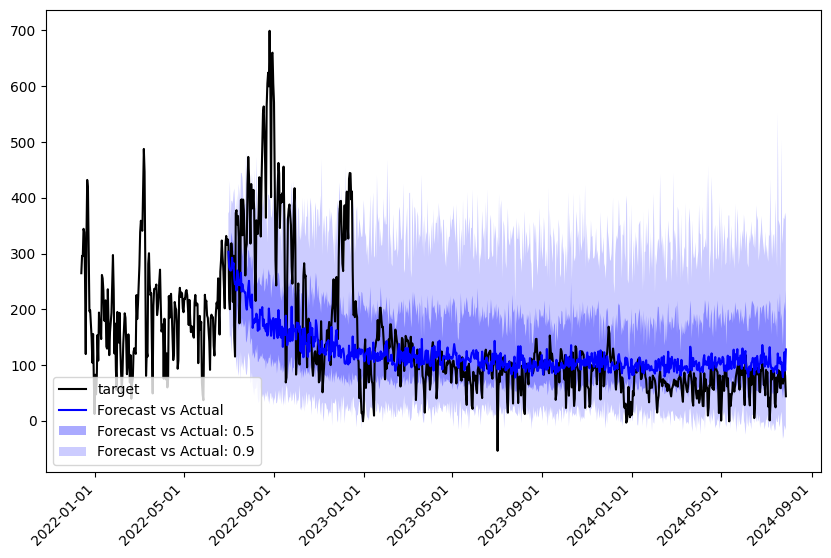

In [184]:
# Prepare the Moirai model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create predictor and generate forecasts
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

# Prepare iterators for inputs, labels, and forecasts
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

# Create a single plot (instead of a grid)
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Plot a single instance using plot_next_multi
plot_next_multi(
    ax,  # Pass the single axis instead of a grid
    input_it,
    label_it,
    forecast_it,
    context_length=200,  # Adjust based on your context length
    intervals=(0.5, 0.9),  # Confidence intervals (50% and 90%)
    dim=None,  # Set dimension to None if single-dimensional
    name="Forecast vs Actual",
    show_label=True,  # Show labels in the plot
)

# Display the plot
plt.show()


## Approach with PandasDataset

### Creating a GluonTs data frame

In [ ]:
# Load the data
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

# Reset the index
df = df.reset_index()

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Ensure the DataFrame is sorted by the index
df.sort_index(inplace=True)

# Setting daily frequency
df = df.asfreq('D')

# Create column called item_id with only 0
df['item_id'] = 0

df.columns

In [32]:
ds = PandasDataset.from_long_dataframe(df, 
    freq='D', 
    target = 'Day_ahead_price (€/MWh)',
    item_id='item_id',
    feat_dynamic_real=['Solar_radiation (W/m2)', 'Wind_speed (m/s)',
       'Temperature (°C)', 'Biomass (GWh)', 'Hard_coal (GWh)', 'Hydro (GWh)',
       'Lignite (GWh)', 'Natural_gas (GWh)', 'Other (GWh)',
       'Pumped_storage_generation (GWh)', 'Solar_energy (GWh)',
       'Wind_offshore (GWh)', 'Wind_onshore (GWh)',
       'Net_total_export_import (GWh)', 'BEV_vehicles', 'Oil_price (EUR)',
       'TTF_gas_price (€/MWh)', 'Nuclear_energy (GWh)'])

In [33]:
ds

PandasDataset<size=1, freq=D, num_feat_dynamic_real=18, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [34]:
import torch
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import plotly.graph_objs as go

# Constants
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
PDT = 790  # prediction length: any positive integer
CTX = 600  # context length: any positive integer
PSZ =  "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 64  # batch size: any positive integer
TEST = 790  # test set length: any positive integer

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

# Prepare pre-trained model by downloading model weights from huggingface hub
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=200,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

# Prepare data for Plotly plotting
input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

# Convert tensors to NumPy arrays if needed
inp_values = inp['target'].numpy() if torch.is_tensor(inp['target']) else inp['target']
label_values = label['target'].numpy() if torch.is_tensor(label['target']) else label['target']
forecast_values = forecast.mean.numpy() if torch.is_tensor(forecast.mean) else forecast.mean


In [35]:
# Convert 'start' to a timestamp if necessary
start_date = inp['start'].to_timestamp() if hasattr(inp['start'], 'to_timestamp') else pd.Timestamp(inp['start'])

# Generate test period dates
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=len(inp_values))
test_dates = pd.date_range(start=test_start_date, periods=PDT, freq='D')

# Confidence interval traces with reduced dominance
confidence_trace_upper = go.Scatter(
    x=test_dates,
    y=forecast.quantile(0.9).numpy() if torch.is_tensor(forecast.quantile(0.9)) else forecast.quantile(0.9),
    mode='lines',
    name='Confidence Interval Upper',
    line=dict(color='grey', width=1, dash='dot'),
    fill='tonexty',
    fillcolor='rgba(169, 169, 169, 0.2)',  # Light grey fill with reduced opacity
    showlegend=False
)

confidence_trace_lower = go.Scatter(
    x=test_dates,
    y=forecast.quantile(0.1).numpy() if torch.is_tensor(forecast.quantile(0.1)) else forecast.quantile(0.1),
    mode='lines',
    name='Confidence Interval Lower',
    line=dict(color='grey', width=1, dash='dot'),
    fill='tonexty',
    fillcolor='rgba(169, 169, 169, 0.2)',  # Light grey fill with reduced opacity
    showlegend=False
)

# Plotting with Plotly (focusing on the test period)
forecast_trace = go.Scatter(
    x=test_dates,
    y=forecast_values,
    mode='lines',
    name='Forecasted Data',
    line=dict(color='darkred', dash='solid')
)

label_trace = go.Scatter(
    x=test_dates,
    y=label_values,
    mode='lines',
    name='Actual Test Data',
    line=dict(color='darkgreen', dash='solid')
)

# Update layout for better visualization
layout = go.Layout(
    title=f"Test Period Data: Forecast vs Actual (Prediction Length: {PDT}, Context Length: {CTX})",
    xaxis=dict(title='Date', range=[test_dates[0], test_dates[-1]]),  # Set x-axis range to focus on the test period
    yaxis=dict(title='Value'),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
)

# Ensure the actual and forecasted data are added last to bring them to the front
fig = go.Figure(data=[confidence_trace_lower, confidence_trace_upper, forecast_trace, label_trace], layout=layout)
fig.show()

In [36]:
mse = mean_squared_error(label_values, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(label_values, forecast_values)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 13642.560130620514
Root Mean Squared Error (RMSE): 116.80137041413732
Mean Absolute Error (MAE): 74.77944020911107


## Approach for testing multiple parameter combinations

In [18]:
# Define the length of the test set 
TEST = 790  # test set length: any positive integer
PDT = 790

# Re-run the model with the best parameters
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Ensure windows is an integer
windows = max(1, int(TEST // PDT))

test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=windows,
    distance=PDT,
)


In [19]:
import torch
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed  # Import for parallelization

# Constants
SIZE = "base"  # model size: choose from {'small', 'base', 'large'}
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}

# List of parameter combinations to try
PDT = 720  # Use a smaller test data length for prediction length
CTX_list = [200]  # Context lengths to try
BSZ_list = [32]  # Batch sizes to try
NUM_SAMPLES_list = [100]  # Different num_samples to try

# Ensure ds is defined correctly
# Assuming ds is the dataset loaded as PandasDataset
TEST = 790  # Set TEST length to a known constant or compute dynamically based on the dataset

# Function to run a single combination
def run_model(CTX, BSZ, num_samples):
    print(f"Training with CTX={CTX}, BSZ={BSZ}, num_samples={num_samples}")

    # Split into train/test set
    train, test_template = split(ds, offset=-TEST)  # Assign last TEST time steps as test set

    # Ensure test length
    TEST_LEN = len(test_template.data) if hasattr(test_template, 'data') else TEST  # Safe length calculation

    # Compute the number of windows and ensure it's an integer
    windows = max(1, TEST_LEN // PDT)  # Number of windows for the entire test set

    # Construct rolling window evaluation
    test_data = test_template.generate_instances(
        prediction_length=PDT,  # Prediction length for the entire test data
        windows=windows,  # Number of windows for the entire test set
        distance=PDT,  # Full distance to avoid overlapping
    )

    # Prepare pre-trained model by downloading model weights from huggingface hub
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=num_samples,  # Use varying num_samples
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

    predictor = model.create_predictor(batch_size=BSZ)
    forecasts = predictor.predict(test_data.input)

    # Prepare data for Plotly plotting
    input_it = iter(test_data.input)
    label_it = iter(test_data.label)
    forecast_it = iter(forecasts)

    inp = next(input_it)
    label = next(label_it)
    forecast = next(forecast_it)

    # Convert tensors to NumPy arrays if needed
    inp_values = inp['target'].numpy() if torch.is_tensor(inp['target']) else inp['target']
    label_values = label['target'].numpy() if torch.is_tensor(label['target']) else label['target']
    forecast_values = forecast.mean.numpy() if torch.is_tensor(forecast.mean) else forecast.mean

    # Compute error metrics
    mse = mean_squared_error(label_values, forecast_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(label_values, forecast_values)

    return (CTX, BSZ, num_samples, rmse, mse, mae)

# Parallel execution using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=1) as executor:
    futures = [
        executor.submit(run_model, CTX, BSZ, num_samples)
        for CTX in CTX_list
        for BSZ in BSZ_list
        for num_samples in NUM_SAMPLES_list
    ]

    # Collect results as they complete
    for future in as_completed(futures):
        CTX, BSZ, num_samples, rmse, mse, mae = future.result()
        results_df.loc[len(results_df)] = [CTX, BSZ, num_samples, rmse, mse, mae]

# Find the best combination with the lowest RMSE and MSE
best_combination = results_df.sort_values(by=['RMSE', 'MSE']).iloc[0]
best_CTX = int(best_combination['CTX'])
best_BSZ = int(best_combination['BSZ'])
best_num_samples = int(best_combination['num_samples'])

print(results_df)
print(f"Best combination with least RMSE and MSE: CTX={best_CTX}, BSZ={best_BSZ}, num_samples={best_num_samples}")



Training with CTX=200, BSZ=32, num_samples=100


NameError: name 'results_df' is not defined

In [49]:
# Re-run the model with the best parameters
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Ensure windows is an integer
windows = max(1, int(TEST // PDT))

test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=windows,
    distance=PDT,
)

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-{SIZE}"),
    prediction_length=PDT,
    context_length=best_CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=best_BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

inp_values = inp['target'].numpy() if torch.is_tensor(inp['target']) else inp['target']
label_values = label['target'].numpy() if torch.is_tensor(label['target']) else label['target']
forecast_values = forecast.mean.numpy() if torch.is_tensor(forecast.mean) else forecast.mean

start_date = inp['start'].to_timestamp() if hasattr(inp['start'], 'to_timestamp') else pd.Timestamp(inp['start'])

test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=len(inp_values))
test_dates = pd.date_range(start=test_start_date, periods=PDT, freq='D')

confidence_trace_upper = go.Scatter(
    x=test_dates,
    y=forecast.quantile(0.9).numpy() if torch.is_tensor(forecast.quantile(0.9)) else forecast.quantile(0.9),
    mode='lines',
    name='Confidence Interval Upper',
    line=dict(color='grey', width=1, dash='dot'),
    fill='tonexty',
    fillcolor='rgba(169, 169, 169, 0.2)',  # Light grey fill with reduced opacity
    showlegend=False
)

confidence_trace_lower = go.Scatter(
    x=test_dates,
    y=forecast.quantile(0.1).numpy() if torch.is_tensor(forecast.quantile(0.1)) else forecast.quantile(0.1),
    mode='lines',
    name='Confidence Interval Lower',
    line=dict(color='grey', width=1, dash='dot'),
    fill='tonexty',
    fillcolor='rgba(169, 169, 169, 0.2)',  # Light grey fill with reduced opacity
    showlegend=False
)

forecast_trace = go.Scatter(
    x=test_dates,
    y=forecast_values,
    mode='lines',
    name='Forecasted Data',
    line=dict(color='darkred', dash='solid')
)

label_trace = go.Scatter(
    x=test_dates,
    y=label_values,
    mode='lines',
    name='Actual Test Data',
    line=dict(color='darkgreen', dash='solid')
)

layout = go.Layout(
    title=f"Best Model: Forecast vs Actual (PDT: {PDT}, CTX: {best_CTX}, BSZ: {best_BSZ})",
    xaxis=dict(title='Date', range=[test_dates[0], test_dates[-1]]),  # Set x-axis range to focus on the test period
    yaxis=dict(title='Value'),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
)

fig = go.Figure(data=[confidence_trace_lower, confidence_trace_upper, forecast_trace, label_trace], layout=layout)
fig.show()
